In [1]:
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
import pandas as pd
np.random.seed(1)
df1 = pd.read_csv(r"D:\Learn\BJ13_M32x32_T30_In.csv")



array1 = df1.to_numpy()


In [2]:
def dell(array1,missing_rate):
    array2 = array1 * np.round(np.random.rand(array1.shape[0], array1.shape[1]) + 0.5 - missing_rate)
    return array2

In [3]:
def min_max_normalize(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    return (arr - arr_min) / (arr_max - arr_min)

In [4]:
print(array1.shape)
X0=array1[:32,:]
#X0 = min_max_normalize(X0)
X=dell(X0,0.5)
print(np.max(X),np.max(X0))

X0=X0.reshape(32,32,32)
print(X)
print(X.shape)
X=X.reshape(32,32,32)
print(X0)


(4887, 1024)
965.0 965.0
[[ 0. 12.  0. ... 18.  0.  5.]
 [ 0.  0. 15. ...  0.  0.  0.]
 [ 0.  4.  9. ...  6.  0.  0.]
 ...
 [ 0. 18.  0. ... 33.  0.  0.]
 [ 0. 11. 33. ... 26. 30.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]]
(32, 1024)
[[[  0.  12.  19. ...   2.   3.  40.]
  [  0.   7.  10. ...  17.   6.  84.]
  [  0.   6.   3. ...  20. 198. 148.]
  ...
  [  0.   1.   5. ...   8.   7.   1.]
  [  0.   1.   3. ...   8.   0.   4.]
  [  0.   2.   2. ...  18.  14.   5.]]

 [[  0.   5.  15. ...   1.   2.  33.]
  [  0.   5.   4. ...  10.   7.  72.]
  [  0.   2.   6. ...   5. 156.  86.]
  ...
  [  2.   2.   3. ...   5.   4.   1.]
  [  1.   1.   1. ...   7.   1.   0.]
  [  0.   1.   0. ...   6.   4.   2.]]

 [[  0.   4.   9. ...   1.   1.  16.]
  [  0.   5.   3. ...   8.   4.  38.]
  [  0.   5.   2. ...   8.  83.  60.]
  ...
  [  0.   1.   2. ...   0.   0.   1.]
  [  0.   1.   0. ...   3.   0.   1.]
  [  0.   1.   1. ...   6.   3.   2.]]

 ...

 [[  0.  18.  55. ...   8.   3.  37.]
  [  0.  18.  30. ..

In [5]:
def augmentation(matrix, target_shape):
    original_shape = matrix.shape
    
    if target_shape[0] < original_shape[0] or target_shape[1] < original_shape[1]:
        raise ValueError("目标维度必须大于等于原始矩阵的维度")
    augmented_matrix = np.zeros(target_shape)
    augmented_matrix[:original_shape[0], :original_shape[1]] = matrix
    
    return augmented_matrix

In [ ]:
import tensorly as tl
from tensorly.decomposition import tucker
def fold(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(int(tensor_size.shape[0])):
        if i != mode:
            index.append(int(i))
    size = []
    for i in index:
        size.append(int(tensor_size[i]))
    return np.moveaxis(np.reshape(mat, size, order = 'F'), 0, mode)
def unfold(z,rank):
    return np.reshape(np.moveaxis(z, rank, 0), (z.shape[rank], -1),order = 'F')
def update_cg(var, r, q, Aq, rold):
    if(rold==0):
        print("rold出现错误")
        print(var,r,q,Aq,rold)
    if(np.inner(q, Aq)==0):
        print("内积出错")
        print("q:",q)
        print("Aq",Aq)
    alpha = rold / np.inner(q, Aq)
    var = var + alpha * q
    r = r - alpha * Aq
    rnew = np.inner(r, r)
    q = r + (rnew / rold) * q
    return var, r, q, rnew
def ell_G(G, S, m_kron_r, K,n):
    return S.T @ ((S @ G @ m_kron_r.T) * K) @ m_kron_r + n * G
def conj_grad_G(G, S, R, M, X, K, n,maxiter = 5):
    dim1, dim2 = G.shape
    g=G.reshape(-1, order = 'F')
    m_kron_r = np.kron(M, R)
    r = np.reshape(S.T@X@m_kron_r-ell_G(G,S,m_kron_r,K,n) ,-1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (dim1, dim2), order = 'F')
        Aq = np.reshape(ell_G(Q,S,m_kron_r,K,n), -1, order = 'F')
        g, r, q, rold = update_cg(g, r, q, Aq, rold)
    return np.reshape(g, (dim1, dim2), order = 'F')
def ell_S(G, S, m_kron_r,K,Q,H,a,b,n,r):
    aug=augmentation(Q@H,(S.shape[0],S.shape[0]))
    return ((S@G@m_kron_r.T)*K)@m_kron_r@G.T+n*S-r*(S-a*b*aug@S)@(np.eye(Q.shape[0])-a*b*H.T@Q.T)
def conj_grad_S(G, S, R, M, X, K,Q1,H,a,b,n ,r1,maxiter = 5):
    dim1, dim2 = S.shape
    s=S.reshape(-1, order = 'F')
    m_kron_r = np.kron(M, R)
    r=np.reshape(X@m_kron_r@G.T-ell_S(G, S, m_kron_r,K,Q1,H,a,b,n,r1) ,-1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (dim1, dim2), order = 'F')
        Aq = np.reshape(ell_S(G, Q, m_kron_r,K,Q1,H,a,b,n,r1), -1, order = 'F')
        s, r, q, rold = update_cg(s, r, q, Aq, rold)        
    return np.reshape(s, (dim1, dim2), order = 'F')
def ell_R(G, R, m_kron_s,K,Q,H,a,b,n,r):
    aug=augmentation(Q@H,(R.shape[0],R.shape[0]))
    return ((R@G@m_kron_s.T)*K)@m_kron_s@G.T+n*R-r*(R-a*b*aug@R)@(np.eye(Q.shape[0])-a*b*H.T@Q.T)
def conj_grad_R(G, S, R, M, X, K,Q1,H,a,b,n ,r1,maxiter = 5):
    dim1, dim2 = R.shape
    rr=R.reshape(-1, order = 'F')
    m_kron_s = np.kron(M, S)
    r=np.reshape(X@m_kron_s@G.T-ell_R(G, R, m_kron_s,K,Q1,H,a,b,n,r1) ,-1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (dim1, dim2), order = 'F')
        Aq = np.reshape(ell_R(G, Q, m_kron_s,K,Q1,H,a,b,n,r1), -1, order = 'F')
        rr, r, q, rold = update_cg(rr, r, q, Aq, rold)        
    return np.reshape(rr, (dim1, dim2), order = 'F')
def ell_M(G, M, r_kron_s,K,Q,H,a,b,n,r):
    aug=augmentation(Q@H,(M.shape[0],M.shape[0]))
    return ((M@G@r_kron_s.T)*K)@r_kron_s@G.T+n*M-r*(M-a*b*aug@M)@(np.eye(Q.shape[0])-a*b*H.T@Q.T)
def conj_grad_M(G, S, R, M, X, K,Q1,H,a,b,n,r1 ,maxiter = 5):
    dim1, dim2 = M.shape
    m=M.reshape(-1, order = 'F')
    r_kron_s = np.kron(R, S)
    r=np.reshape(X@r_kron_s@G.T-ell_M(G, M, r_kron_s,K,Q1,H,a,b,n,r1) ,-1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (dim1, dim2), order = 'F')
        Aq = np.reshape(ell_M(G, Q, r_kron_s,K,Q1,H,a,b,n,r1), -1, order = 'F')
        m, r, q, rold = update_cg(m, r, q, Aq, rold) 
    return np.reshape(m, (dim1, dim2 ), order = 'F')
def conj_grad_Q_H(S,R,M,Q1, H, a, b,maxiter = 3):
    def ell_Q1(Z,Q, H, a, b):   
        z=(Z@Z.T)[:Q.shape[0],:Q.shape[0]]
        return (a*b*Q@H@z@H.T)
    def conj_grad_Q(Q1, H, S,R,M, a, b,maxiter = 3):
        Z=M
        z=(Z@Z.T)[:H.shape[0],:H.shape[0]]
        rank, dim1 = Q1.shape
        q1=Q1.reshape(-1, order = 'F')
        r=np.reshape(a*b*z@H.T-ell_Q1(Z,Q1, H, a, b) ,-1, order = 'F')
        
        q = r.copy()
        rold = np.inner(r, r)
        for it in range(maxiter):
            Q = np.reshape(q, (rank, dim1), order = 'F')
            Aq = np.reshape(ell_Q1(Z,Q, H, a, b), -1, order = 'F')
            q1, r, q, rold = update_cg(q1, r, q, Aq, rold) 
        return np.reshape(q1, (rank, dim1), order = 'F')
    def ell_H(Z,Q1, H, a, b):
        z=(Z@Z.T)[:H.shape[0],:H.shape[0]]
        return (a*b*Q1@H@z@Q1.T)
    def conj_grad_H(Q1, H, S,R,M, a, b,maxiter = 5):
        Z=M
        z=(Z@Z.T)[:H.shape[0],:H.shape[0]]
        rank, dim1 = H.shape
        h=H.reshape(-1, order = 'F')
        r=np.reshape(a*b*z@Q1.T-ell_H(Z,Q1, H, a, b) ,-1, order = 'F')
        
        q = r.copy()
        rold = np.inner(r, r)
        for it in range(maxiter):
            Q = np.reshape(q, (rank, dim1), order = 'F')
            Aq = np.reshape(ell_H(Z,Q, H, a, b), -1, order = 'F')
            h, r, q, rold = update_cg(h, r, q, Aq, rold) 
        return np.reshape(h, (rank, dim1), order = 'F')
    Q1=conj_grad_Q(Q1, H, S,R,M, a, b)
    H=conj_grad_H(Q1, H, S,R,M, a, b)
    return Q1,H           
def conj_grad_a_b(Q, H, Z, a, b,maxiter = 5):
    def ell_a(Q, H, Z, a, b):
        return (a*b*b*Q@H)
    def ell_b(Q, H, Z, a, b):
        return (a*a*b*Q@H)
    def conj_grad_a(Q1, H, Z, a, b,maxiter = 5):
        I=np.eye(Q1.shape[0])
        r=np.reshape(b*I-ell_a(Q1,H, Z,a, b) ,-1, order = 'F')        
        q = r.copy()
        rold = np.inner(r, r)
        for it in range(maxiter):
            Q = q[0]
            Aq = np.reshape(ell_a(Q1,H, Z,Q, b), -1, order = 'F')
            a, r, q, rold = update_cg(a, r, q, Aq, rold) 
        return a[0]
    def conj_grad_b(Q1, H, Z, a, b,maxiter = 5):
        I=np.eye(Q1.shape[0])
        r=np.reshape(a*I-ell_b(Q1, H,Z, a, b) ,-1, order = 'F')        
        q = r.copy()
        rold = np.inner(r, r)
        for it in range(maxiter):
            Q = q[0]
            Aq = np.reshape(ell_b(Q1, H, Z, a, Q), -1, order = 'F')
            b, r, q, rold = update_cg(b, r, q, Aq, rold) 
        return b[0]
    a=np.mean(H.T@Q.T)/b
    b=np.mean(H.T@Q.T)/a
    return a,b

def Star(X0,X,rank,n,r,rthers,maxiter):
    #Create K
    #K = np.zeros(X.shape) 
    #K[(X0 != 0) & (X == 0)] = 1
    dim=X.shape
    
    #Initialize G S R M Q H A B randomly
    G = np.random.randn(rank[0], rank[1], rank[2])
    S = np.random.randn(dim[0], rank[0])
    R = np.random.randn(dim[1], rank[1])
    M = np.random.randn(dim[2], rank[2])
    Q = np.random.randn(rank[2], rank[2])
    H = np.random.randn(rank[2], rank[2])
    #G = np.random.uniform(0,1,[rank[0], rank[1], rank[2]])
    #S = np.random.uniform(0,1,[X.shape[0], rank[0]])
    #R = np.random.uniform(0,1,[X.shape[1], rank[1]])
    #M = np.random.uniform(0,1,[X.shape[2],rank[2]])
    #print(G.shape,S.shape,R.shape,M.shape)
    #Q = np.random.uniform(0,1,[rank[2], rank[2]])
    #H = np.random.uniform(0,1,[rank[2], rank[2]])
    a = np.random.uniform(0, 1)
    b = np.random.uniform(0, 1)
    #iter
    pos_test = np.where((X0 != 0) & (X == 0))
    K = X != 0
    tensor_hat = X.copy()
    show_iter=5
    for iter in range(maxiter):
        G1=unfold(G,0)
        K1=unfold(K,0)
        X1=unfold(X,0)
        G1 = conj_grad_G(G1, S, R, M, X1, K1,n)
        S = conj_grad_S(G1, S, R, M, X1, K1,Q,H,a,b,n ,r)
        G = fold(G1, rank, 0)
        G2=unfold(G,1)
        K2=unfold(K,1)
        X2=unfold(X,1)
        R= conj_grad_R(G2, S, R, M, X2, K2,Q,H,a,b,n ,r)  
        G3=unfold(G,2)
        K3=unfold(K,2)
        X3=unfold(X,2)
        M= conj_grad_M(G3, S, R, M, X3, K3,Q,H,a,b,n ,r)
        Q, H = conj_grad_Q_H(S,R,M,Q, H, a, b)
        a, b = conj_grad_a_b(Q, H,R ,a, b)            
        print(a,b)
        temp = unfold(np.einsum('rtq, sq -> rts', 
                                 np.einsum('rpq, tp -> rtq', G, R), M), 0)
        tensor_hat = fold(S @ temp, np.array(dim), 0)
        if (iter + 1) % show_iter == 0 or iter==0:
            print('Iter: {}'.format(iter + 1))
            rse = (np.linalg.norm(tensor_hat[pos_test] - X0[pos_test], 2) 
                  / np.linalg.norm(X0[pos_test], 2))
            print(rse)
            print()
            #print(compute_rse1(X,pos_test, t3))               
    return tensor_hat,G,S,R,M,Q,H,a,b

In [13]:
print(array1.shape)
X0=array1[:320,:]
X0=X0.reshape(320,32,32)
M, N, T = X0.shape
random_tensor = np.random.rand(M, N, T)
#X0 = min_max_normalize(X0)
p = 0.8
X = X0 * np.round(random_tensor + 0.5 - p)
print(np.max(X),np.max(X0))
print(X.shape)

(4887, 1024)
983.0 1045.0
(320, 32, 32)


In [15]:
rank=np.array([8, 8, 8])
thers=0.001
maxiter=25
n=0.0001
r=0.01

import time
start = time.time()
T3,G,S,R,M,Q,H,a,b=Star(X0,X,rank,n,r,thers,maxiter)
print(G.shape,S.shape,R.shape,M.shape)
#print(S,R,M)



end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
0.9140580017327905

Iter: 5
0.29905466871587016

Iter: 10
0.2752614803473251

Iter: 15
0.27020652387041233

Iter: 20
0.2651543732919873

Iter: 25
0.2637069343088683

Iter: 30
0.26388417888657867

Iter: 35
0.26414340051567287

Iter: 40
0.2643799469644448

Iter: 45
0.26454435786123226

Iter: 50
0.2647283704848621

(8, 8, 8) (320, 8) (32, 8) (32, 8)
Running time: 5 seconds


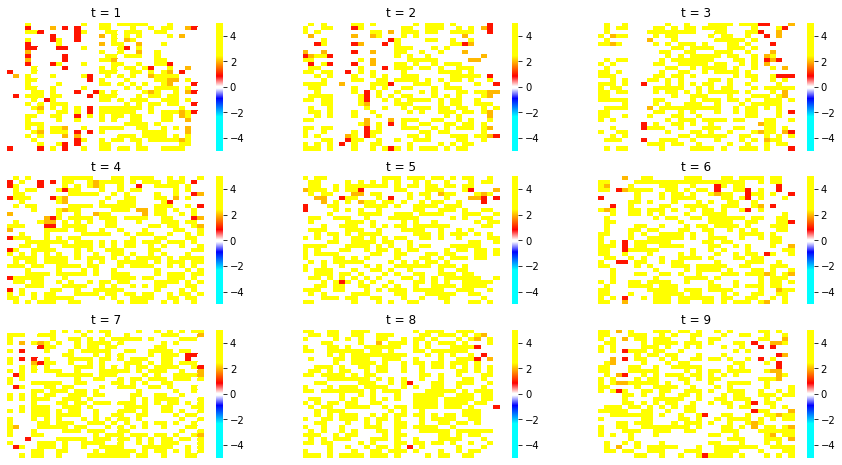

In [149]:
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
color = scipy.io.loadmat(r'D:\Learn\CCcool.mat')
cc = color['CC']
newcmp = LinearSegmentedColormap.from_list('', cc)

fig = plt.figure(figsize = (15, 8))
for t in range(9):
    ax = fig.add_subplot(3, 3, t + 1)
    sns.heatmap(X[:, :, t], cmap = newcmp, vmin = -5, vmax = 5)
    plt.title('t = {}'.format(t + 1))
    plt.xticks([])
    plt.yticks([])


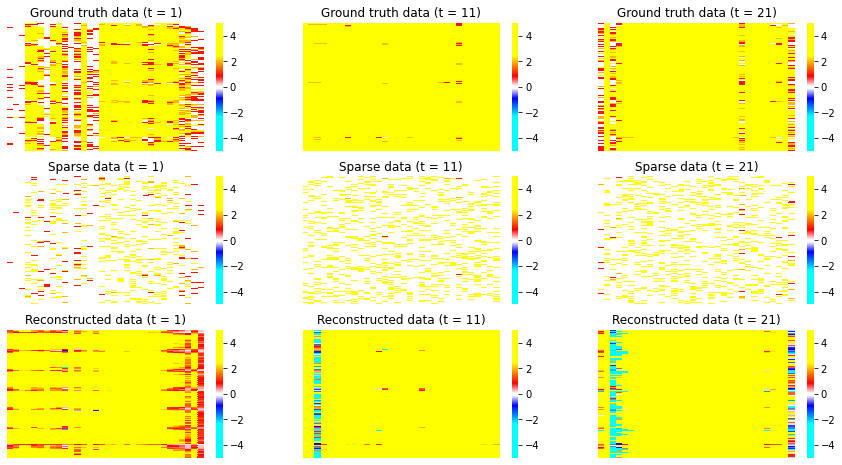

In [16]:
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
color = scipy.io.loadmat(r'D:\Learn\CCcool.mat')
cc = color['CC']
newcmp = LinearSegmentedColormap.from_list('', cc)

fig = plt.figure(figsize = (15, 8))
i = 1
for t in [0, 10, 20]:
    ax = fig.add_subplot(3, 3, i)
    sns.heatmap(X0[:, :, t], cmap = newcmp, vmin = -5, vmax = 5)
    plt.title('Ground truth data (t = {})'.format(t + 1))
    plt.xticks([])
    plt.yticks([])
    i += 1
for t in [0, 10, 20]:
    ax = fig.add_subplot(3, 3, i)
    sns.heatmap(X[:, :, t], cmap = newcmp, vmin = -5, vmax = 5)
    plt.title('Sparse data (t = {})'.format(t + 1))
    plt.xticks([])
    plt.yticks([])
    i += 1
for t in [0, 10, 20]:
    ax = fig.add_subplot(3, 3, i)
    sns.heatmap(T3[:, :, t], cmap = newcmp, vmin = -5, vmax = 5)
    plt.title('Reconstructed data (t = {})'.format(t + 1))
    plt.xticks([])
    plt.yticks([])
    i += 1